# Model Inference Script

This notebook provides a complete inference pipeline for all trained models:

## Available Models:
- **Few-Shot**: CLIP KNN, DINOv2 KNN, CLIP Linear, DINOv2 Linear
- **BitFit**: CLIP & DINOv2 (bias-only fine-tuning)
- **Prefix Tuning**: CLIP & DINOv2 (learnable prefix tokens)
- **LoRA**: CLIP & DINOv2 (low-rank adaptation)
- **Full Fine-tuning**: CLIP & DINOv2

## Usage:
1. Run cells in order to load model definitions and inference function
2. Use `run_all_models_inference(image_paths)` to get predictions
3. Use the results display cell to compare model performance

## Requirements:
- Checkpoints in `./checkpoints/` directory
- Balanced dataset metadata in `./balanced_dataset/dataset_metadata.json`

In [2]:
# ============================================================================
# MODEL CLASS DEFINITIONS FOR FINE-TUNING METHODS
# ============================================================================

import torch
import torch.nn as nn
from peft import LoraConfig, get_peft_model

# BitFit Models (Bias-only fine-tuning)
class BitFitCLIP(nn.Module):
    def __init__(self, clip_model, num_classes):
        super().__init__()
        self.vision_model = clip_model.vision_model
        # Freeze all parameters
        for param in self.vision_model.parameters():
            param.requires_grad = False
        # Unfreeze only bias parameters
        for name, param in self.vision_model.named_parameters():
            if 'bias' in name:
                param.requires_grad = True
        
        # Classifier head
        self.classifier = nn.Linear(768, num_classes)  # CLIP ViT-B/32 hidden size is 768
    
    def forward(self, x):
        features = self.vision_model(pixel_values=x).last_hidden_state[:, 0, :]
        return self.classifier(features)

class BitFitDINO(nn.Module):
    def __init__(self, dino_model, num_classes):
        super().__init__()
        self.backbone = dino_model
        # Freeze all parameters
        for param in self.backbone.parameters():
            param.requires_grad = False
        # Unfreeze only bias parameters
        for name, param in self.backbone.named_parameters():
            if 'bias' in name:
                param.requires_grad = True
        
        # Classifier head
        self.classifier = nn.Linear(384, num_classes)  # DINOv2 vits14 hidden size is 384
    
    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

# Prefix Tuning Models
class PrefixCLIP(nn.Module):
    def __init__(self, clip_model, num_classes, prefix_length=10):
        super().__init__()
        self.vision_model = clip_model.vision_model
        self.prefix_length = prefix_length
        # Freeze base model
        for param in self.vision_model.parameters():
            param.requires_grad = False
        
        # Learnable prefix tokens
        self.prefix_tokens = nn.Parameter(torch.randn(1, prefix_length, 768))
        self.classifier = nn.Linear(768, num_classes)
    
    def forward(self, x):
        # Get image features
        features = self.vision_model(pixel_values=x).last_hidden_state  # [B, seq_len, 768]
        batch_size = features.size(0)
        
        # Expand prefix tokens for batch
        prefix = self.prefix_tokens.expand(batch_size, -1, -1)
        
        # Concatenate prefix with features
        features = torch.cat([prefix, features], dim=1)
        
        # Use CLS token (first token after prefix)
        cls_features = features[:, self.prefix_length, :]
        return self.classifier(cls_features)

class PrefixDINO(nn.Module):
    def __init__(self, dino_model, num_classes, prefix_length=10):
        super().__init__()
        self.backbone = dino_model
        self.prefix_length = prefix_length
        # Freeze base model
        for param in self.backbone.parameters():
            param.requires_grad = False
        
        # Learnable prefix tokens (DINOv2 small has 384 dim)
        self.prefix_tokens = nn.Parameter(torch.randn(1, prefix_length, 384))
        self.classifier = nn.Linear(384, num_classes)
    
    def forward(self, x):
        # DINOv2 returns [CLS] token by default
        features = self.backbone(x)  # [B, 384]
        # Add prefix contribution
        batch_size = features.size(0)
        prefix = self.prefix_tokens.expand(batch_size, -1, -1).mean(dim=1)  # Average prefix tokens
        combined_features = features + prefix
        return self.classifier(combined_features)

# LoRA Models
class LoraCLIP(nn.Module):
    def __init__(self, clip_model, num_classes):
        super().__init__()
        self.vision_model = clip_model.vision_model
        # Freeze base model
        for param in self.vision_model.parameters():
            param.requires_grad = False
        
        # Apply LoRA to attention layers
        lora_config = LoraConfig(
            r=8,  # LORA_R
            lora_alpha=16,  # LORA_ALPHA
            target_modules=["q_proj", "v_proj"],  # Apply to attention layers
            lora_dropout=0.1,  # LORA_DROPOUT
            bias="none"
        )
        
        self.vision_model = get_peft_model(self.vision_model, lora_config)
        self.classifier = nn.Linear(768, num_classes)
    
    def forward(self, x):
        features = self.vision_model(pixel_values=x).last_hidden_state[:, 0, :]
        return self.classifier(features)

class LoraDINO(nn.Module):
    def __init__(self, dino_model, num_classes):
        super().__init__()
        self.backbone = dino_model
        # Freeze base model
        for param in self.backbone.parameters():
            param.requires_grad = False
        
        # Apply LoRA
        lora_config = LoraConfig(
            r=8,  # LORA_R
            lora_alpha=16,  # LORA_ALPHA
            target_modules=["qkv"],  # DINOv2 uses combined qkv
            lora_dropout=0.1,  # LORA_DROPOUT
            bias="none"
        )
        
        self.backbone = get_peft_model(self.backbone, lora_config)
        self.classifier = nn.Linear(384, num_classes)
    
    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

# Full Fine-tuning Models
class FullFinetuneCLIP(nn.Module):
    def __init__(self, clip_model, num_classes):
        super().__init__()
        self.vision_model = clip_model.vision_model
        # Unfreeze all parameters
        for param in self.vision_model.parameters():
            param.requires_grad = True
        
        self.classifier = nn.Linear(768, num_classes)
    
    def forward(self, x):
        features = self.vision_model(pixel_values=x).last_hidden_state[:, 0, :]
        return self.classifier(features)

class FullFinetuneDINO(nn.Module):
    def __init__(self, dino_model, num_classes):
        super().__init__()
        self.backbone = dino_model
        # Unfreeze all parameters
        for param in self.backbone.parameters():
            param.requires_grad = True
        
        self.classifier = nn.Linear(384, num_classes)
    
    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

print("✓ Model class definitions loaded (BitFit, Prefix, LoRA, Full Fine-tuning)")

/home/crimson/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Model class definitions loaded (BitFit, Prefix, LoRA, Full Fine-tuning)


In [3]:
# ============================================================================
# EXTENDED INFERENCE FUNCTION - Including Fine-tuned Models
# ============================================================================

def run_all_models_inference(image_paths, checkpoint_dir="checkpoints", verbose=True):
    """
    Run inference on images using ALL models including fine-tuned ones.
    
    Args:
        image_paths: List of paths to images
        checkpoint_dir: Directory containing checkpoints
        verbose: Print detailed results
    
    Returns:
        Dictionary with predictions from all models
    """
    import pickle
    import torch
    import numpy as np
    from PIL import Image
    from pathlib import Path
    from transformers import CLIPProcessor, CLIPModel
    from torchvision import transforms
    
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    
    if verbose:
        print("="*80)
        print("RUNNING INFERENCE ON ALL MODELS (Including Fine-tuned)")
        print("="*80)
        print(f"\nNumber of images: {len(image_paths)}")
        print(f"Device: {DEVICE}\n")
    
    results = {}
    checkpoint_path = Path(checkpoint_dir)
    
    # Load class names
    import json
    metadata_path = Path("balanced_dataset/dataset_metadata.json")
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
        classes = metadata['classes']
    num_classes = len(classes)
    
    # Load base models
    if verbose: print("Loading base models...")
    clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)
    clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    
    try:
        dinov2_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14', trust_repo=True).to(DEVICE)
    except Exception as e:
        if verbose: print(f"Loading DINOv2 from cache...")
        dinov2_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14', source='github', 
                                      force_reload=False, trust_repo=True).to(DEVICE)
    
    if verbose: print("✓ Base models loaded\n")
    
    # Helper functions
    def extract_clip_features(image_paths):
        features = []
        for img_path in image_paths:
            img = Image.open(img_path).convert('RGB')
            inputs = clip_processor(images=img, return_tensors="pt").to(DEVICE)
            with torch.no_grad():
                img_features = clip_model.get_image_features(**inputs)
            features.append(img_features.cpu().numpy().flatten())
        return np.array(features)
    
    def extract_dino_features(image_paths):
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        features = []
        for img_path in image_paths:
            img = Image.open(img_path).convert('RGB')
            img_tensor = transform(img).unsqueeze(0).to(DEVICE)
            with torch.no_grad():
                img_features = dinov2_model(img_tensor)
            features.append(img_features.cpu().numpy().flatten())
        return np.array(features)
    
    def prepare_clip_batch(image_paths):
        images = [Image.open(p).convert('RGB') for p in image_paths]
        inputs = clip_processor(images=images, return_tensors="pt").to(DEVICE)
        return inputs['pixel_values']
    
    def prepare_dino_batch(image_paths):
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        images = [transform(Image.open(p).convert('RGB')) for p in image_paths]
        return torch.stack(images).to(DEVICE)
    
    # 1. KNN Models
    if (checkpoint_path / "clip_knn.pkl").exists():
        if verbose: print("Running CLIP KNN...")
        with open(checkpoint_path / "clip_knn.pkl", 'rb') as f:
            knn_clip = pickle.load(f)
        clip_features = extract_clip_features(image_paths)
        predictions = knn_clip.predict(clip_features)
        results['clip_knn'] = {'predictions': predictions.tolist(), 
                               'class_names': [classes[p] for p in predictions]}
        if verbose: print(f"✓ CLIP KNN complete")
    
    if (checkpoint_path / "dinov2_knn.pkl").exists():
        if verbose: print("Running DINOv2 KNN...")
        with open(checkpoint_path / "dinov2_knn.pkl", 'rb') as f:
            knn_dino = pickle.load(f)
        dino_features = extract_dino_features(image_paths)
        predictions = knn_dino.predict(dino_features)
        results['dinov2_knn'] = {'predictions': predictions.tolist(),
                                 'class_names': [classes[p] for p in predictions]}
        if verbose: print(f"✓ DINOv2 KNN complete")
    
    # 2. Linear Probe Models
    if (checkpoint_path / "clip_linear.pkl").exists():
        if verbose: print("Running CLIP Linear Probe...")
        with open(checkpoint_path / "clip_linear.pkl", 'rb') as f:
            lr_clip = pickle.load(f)
        if 'clip_features' not in locals():
            clip_features = extract_clip_features(image_paths)
        predictions = lr_clip.predict(clip_features)
        results['clip_linear'] = {'predictions': predictions.tolist(),
                                  'class_names': [classes[p] for p in predictions]}
        if verbose: print(f"✓ CLIP Linear Probe complete")
    
    if (checkpoint_path / "dinov2_linear.pkl").exists():
        if verbose: print("Running DINOv2 Linear Probe...")
        with open(checkpoint_path / "dinov2_linear.pkl", 'rb') as f:
            lr_dino = pickle.load(f)
        if 'dino_features' not in locals():
            dino_features = extract_dino_features(image_paths)
        predictions = lr_dino.predict(dino_features)
        results['dinov2_linear'] = {'predictions': predictions.tolist(),
                                    'class_names': [classes[p] for p in predictions]}
        if verbose: print(f"✓ DINOv2 Linear Probe complete")
    
    # 3. BitFit Models
    if (checkpoint_path / "bitfit_clip_best.pth").exists():
        if verbose: print("Running BitFit CLIP...")
        bitfit_clip = BitFitCLIP(clip_model, num_classes).to(DEVICE)
        checkpoint = torch.load(checkpoint_path / "bitfit_clip_best.pth", map_location=DEVICE, weights_only=False)
        bitfit_clip.load_state_dict(checkpoint['model_state_dict'])
        bitfit_clip.eval()
        
        pixel_values = prepare_clip_batch(image_paths)
        with torch.no_grad():
            outputs = bitfit_clip(pixel_values)
            predictions = torch.argmax(outputs, dim=1).cpu().numpy()
        
        results['bitfit_clip'] = {'predictions': predictions.tolist(),
                                  'class_names': [classes[p] for p in predictions]}
        if verbose: print(f"✓ BitFit CLIP complete")
        del bitfit_clip
        torch.cuda.empty_cache()
    
    if (checkpoint_path / "bitfit_dinov2_best.pth").exists():
        if verbose: print("Running BitFit DINOv2...")
        bitfit_dino = BitFitDINO(dinov2_model, num_classes).to(DEVICE)
        checkpoint = torch.load(checkpoint_path / "bitfit_dinov2_best.pth", map_location=DEVICE, weights_only=False)
        bitfit_dino.load_state_dict(checkpoint['model_state_dict'])
        bitfit_dino.eval()
        
        pixel_values = prepare_dino_batch(image_paths)
        with torch.no_grad():
            outputs = bitfit_dino(pixel_values)
            predictions = torch.argmax(outputs, dim=1).cpu().numpy()
        
        results['bitfit_dinov2'] = {'predictions': predictions.tolist(),
                                    'class_names': [classes[p] for p in predictions]}
        if verbose: print(f"✓ BitFit DINOv2 complete")
        del bitfit_dino
        torch.cuda.empty_cache()
    
    # 4. Prefix Tuning Models
    if (checkpoint_path / "prefix_clip_best.pth").exists():
        if verbose: print("Running Prefix CLIP...")
        prefix_clip = PrefixCLIP(clip_model, num_classes, prefix_length=10).to(DEVICE)
        checkpoint = torch.load(checkpoint_path / "prefix_clip_best.pth", map_location=DEVICE, weights_only=False)
        prefix_clip.load_state_dict(checkpoint['model_state_dict'])
        prefix_clip.eval()
        
        pixel_values = prepare_clip_batch(image_paths)
        with torch.no_grad():
            outputs = prefix_clip(pixel_values)
            predictions = torch.argmax(outputs, dim=1).cpu().numpy()
        
        results['prefix_clip'] = {'predictions': predictions.tolist(),
                                  'class_names': [classes[p] for p in predictions]}
        if verbose: print(f"✓ Prefix CLIP complete")
        del prefix_clip
        torch.cuda.empty_cache()
    
    if (checkpoint_path / "prefix_dinov2_best.pth").exists():
        if verbose: print("Running Prefix DINOv2...")
        prefix_dino = PrefixDINO(dinov2_model, num_classes, prefix_length=10).to(DEVICE)
        checkpoint = torch.load(checkpoint_path / "prefix_dinov2_best.pth", map_location=DEVICE, weights_only=False)
        prefix_dino.load_state_dict(checkpoint['model_state_dict'])
        prefix_dino.eval()
        
        pixel_values = prepare_dino_batch(image_paths)
        with torch.no_grad():
            outputs = prefix_dino(pixel_values)
            predictions = torch.argmax(outputs, dim=1).cpu().numpy()
        
        results['prefix_dinov2'] = {'predictions': predictions.tolist(),
                                    'class_names': [classes[p] for p in predictions]}
        if verbose: print(f"✓ Prefix DINOv2 complete")
        del prefix_dino
        torch.cuda.empty_cache()
    
    # 5. LoRA Models
    if (checkpoint_path / "lora_clip_best.pth").exists():
        if verbose: print("Running LoRA CLIP...")
        lora_clip = LoraCLIP(clip_model, num_classes).to(DEVICE)
        checkpoint = torch.load(checkpoint_path / "lora_clip_best.pth", map_location=DEVICE, weights_only=False)
        lora_clip.load_state_dict(checkpoint['model_state_dict'])
        lora_clip.eval()
        
        pixel_values = prepare_clip_batch(image_paths)
        with torch.no_grad():
            outputs = lora_clip(pixel_values)
            predictions = torch.argmax(outputs, dim=1).cpu().numpy()
        
        results['lora_clip'] = {'predictions': predictions.tolist(),
                                'class_names': [classes[p] for p in predictions]}
        if verbose: print(f"✓ LoRA CLIP complete")
        del lora_clip
        torch.cuda.empty_cache()
    
    if (checkpoint_path / "lora_dinov2_best.pth").exists():
        if verbose: print("Running LoRA DINOv2...")
        lora_dino = LoraDINO(dinov2_model, num_classes).to(DEVICE)
        checkpoint = torch.load(checkpoint_path / "lora_dinov2_best.pth", map_location=DEVICE, weights_only=False)
        lora_dino.load_state_dict(checkpoint['model_state_dict'])
        lora_dino.eval()
        
        pixel_values = prepare_dino_batch(image_paths)
        with torch.no_grad():
            outputs = lora_dino(pixel_values)
            predictions = torch.argmax(outputs, dim=1).cpu().numpy()
        
        results['lora_dinov2'] = {'predictions': predictions.tolist(),
                                  'class_names': [classes[p] for p in predictions]}
        if verbose: print(f"✓ LoRA DINOv2 complete")
        del lora_dino
        torch.cuda.empty_cache()
    
    # 6. Full Fine-tuning Models
    if (checkpoint_path / "full_clip_acc0.92_best.pth").exists():
        if verbose: print("Running Full Fine-tune CLIP...")
        full_clip = FullFinetuneCLIP(clip_model, num_classes).to(DEVICE)
        checkpoint = torch.load(checkpoint_path / "full_clip_acc0.92_best.pth", map_location=DEVICE, weights_only=False)
        full_clip.load_state_dict(checkpoint['model_state_dict'])
        full_clip.eval()
        
        pixel_values = prepare_clip_batch(image_paths)
        with torch.no_grad():
            outputs = full_clip(pixel_values)
            predictions = torch.argmax(outputs, dim=1).cpu().numpy()
        
        results['full_clip'] = {'predictions': predictions.tolist(),
                                'class_names': [classes[p] for p in predictions]}
        if verbose: print(f"✓ Full Fine-tune CLIP complete")
        del full_clip
        torch.cuda.empty_cache()
    
    if (checkpoint_path / "full_dinov2_acc0.95_best.pth").exists():
        if verbose: print("Running Full Fine-tune DINOv2...")
        full_dino = FullFinetuneDINO(dinov2_model, num_classes).to(DEVICE)
        checkpoint = torch.load(checkpoint_path / "full_dinov2_acc0.95_best.pth", map_location=DEVICE, weights_only=False)
        full_dino.load_state_dict(checkpoint['model_state_dict'])
        full_dino.eval()
        
        pixel_values = prepare_dino_batch(image_paths)
        with torch.no_grad():
            outputs = full_dino(pixel_values)
            predictions = torch.argmax(outputs, dim=1).cpu().numpy()
        
        results['full_dinov2'] = {'predictions': predictions.tolist(),
                                  'class_names': [classes[p] for p in predictions]}
        if verbose: print(f"✓ Full Fine-tune DINOv2 complete")
        del full_dino
        torch.cuda.empty_cache()
    
    if verbose:
        print("\n" + "="*80)
        print("ALL MODELS INFERENCE COMPLETE")
        print("="*80)
    
    return results

print("\n✓ Extended inference function defined with all fine-tuning methods.")


✓ Extended inference function defined with all fine-tuning methods.


In [5]:
# ============================================================================
# COMPREHENSIVE RESULTS COMPARISON
# ============================================================================

import pandas as pd

# Create comprehensive results dataframe
results_data = {'Ground Truth': ground_truth}

# Add predictions from each model
for model_name, model_results in results_all.items():
    display_name = model_name.replace('_', ' ').title()
    results_data[display_name] = model_results['class_names']

df = pd.DataFrame(results_data)

# Calculate accuracy for each model
accuracies = {}
for col in df.columns:
    if col != 'Ground Truth':
        correct = (df[col] == df['Ground Truth']).sum()
        accuracies[col] = {
            'correct': correct,
            'total': len(df),
            'accuracy': correct / len(df)
        }

# Sort models by accuracy
sorted_models = sorted(accuracies.items(), key=lambda x: x[1]['accuracy'], reverse=True)

print("\n" + "="*120)
print("COMPREHENSIVE MODEL COMPARISON - 15 TEST IMAGES (One Per Class)")
print("="*120)
print(df.to_string(index=False, max_colwidth=20))

print("\n" + "="*120)
print("ACCURACY RANKING")
print("="*120)
print(f"{'Rank':<6} {'Model':<25} {'Correct':<10} {'Accuracy':<15}")
print("-"*120)
for rank, (model, acc_info) in enumerate(sorted_models, 1):
    print(f"{rank:<6} {model:<25} {acc_info['correct']}/{acc_info['total']:<8} {acc_info['accuracy']*100:>6.1f}%")
print("="*120)

# Group by method type
print("\n" + "="*120)
print("ACCURACY BY METHOD TYPE")
print("="*120)

method_groups = {
    'Few-Shot': ['Clip Knn', 'Dinov2 Knn', 'Clip Linear', 'Dinov2 Linear'],
    'BitFit': ['Bitfit Clip', 'Bitfit Dinov2'],
    'Prefix Tuning': ['Prefix Clip', 'Prefix Dinov2'],
    'LoRA': ['Lora Clip', 'Lora Dinov2'],
    'Full Fine-tuning': ['Full Clip', 'Full Dinov2']
}

for method_type, model_list in method_groups.items():
    print(f"\n{method_type}:")
    for model in model_list:
        if model in accuracies:
            acc = accuracies[model]['accuracy']
            print(f"  {model:<25} {acc*100:>6.1f}%")
        else:
            print(f"  {model:<25} (not found)")

print("\n" + "="*120)

NameError: name 'ground_truth' is not defined

In [6]:
# ============================================================================
# USAGE EXAMPLE - Run inference on your images
# ============================================================================

# Example 1: Single image
image_paths = ["balanced_dataset/test/Human/d_r_22__jpg.rf.21b8a44730be9c4c5070e5e955019e2c.jpg"]
results = run_all_models_inference(image_paths, checkpoint_dir="checkpoints", verbose=True)

# Example 2: Multiple images
# image_paths = [
#     "/path/to/image1.jpg",
#     "/path/to/image2.jpg",
#     "/path/to/image3.jpg"
# ]
# results = run_all_models_inference(image_paths, checkpoint_dir="checkpoints", verbose=True)

# Example 3: Get predictions programmatically
for model_name, model_results in results.items():
    print(f"{model_name}: {model_results['class_names']}")

print("Ready for inference! Use run_all_models_inference(image_paths) to run predictions.")

RUNNING INFERENCE ON ALL MODELS (Including Fine-tuned)

Number of images: 1
Device: cuda

Loading base models...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Using cache found in /home/crimson/.cache/torch/hub/facebookresearch_dinov2_main
/home/crimson/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/crimson/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/crimson/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Using cache fou

✓ Base models loaded

Running CLIP KNN...
✓ CLIP KNN complete
Running DINOv2 KNN...
✓ DINOv2 KNN complete
Running CLIP Linear Probe...
✓ CLIP Linear Probe complete
Running DINOv2 Linear Probe...
✓ DINOv2 Linear Probe complete
Running BitFit CLIP...
✓ BitFit CLIP complete
Running BitFit DINOv2...
✓ BitFit DINOv2 complete
Running Prefix CLIP...
✓ Prefix CLIP complete
Running Prefix DINOv2...
✓ Prefix DINOv2 complete
Running LoRA CLIP...
✓ LoRA CLIP complete
Running LoRA DINOv2...
✓ LoRA DINOv2 complete
Running Full Fine-tune CLIP...
✓ Full Fine-tune CLIP complete
Running Full Fine-tune DINOv2...
✓ Full Fine-tune DINOv2 complete

ALL MODELS INFERENCE COMPLETE
clip_knn: ['Human']
dinov2_knn: ['Human']
clip_linear: ['Human']
dinov2_linear: ['Human']
bitfit_clip: ['Human']
bitfit_dinov2: ['Human']
prefix_clip: ['Human']
prefix_dinov2: ['Human']
lora_clip: ['Human']
lora_dinov2: ['Human']
full_clip: ['Human']
full_dinov2: ['Human']
Ready for inference! Use run_all_models_inference(image_paths

In [7]:
results

{'clip_knn': {'predictions': [4], 'class_names': ['Human']},
 'dinov2_knn': {'predictions': [4], 'class_names': ['Human']},
 'clip_linear': {'predictions': [4], 'class_names': ['Human']},
 'dinov2_linear': {'predictions': [4], 'class_names': ['Human']},
 'bitfit_clip': {'predictions': [4], 'class_names': ['Human']},
 'bitfit_dinov2': {'predictions': [4], 'class_names': ['Human']},
 'prefix_clip': {'predictions': [4], 'class_names': ['Human']},
 'prefix_dinov2': {'predictions': [4], 'class_names': ['Human']},
 'lora_clip': {'predictions': [4], 'class_names': ['Human']},
 'lora_dinov2': {'predictions': [4], 'class_names': ['Human']},
 'full_clip': {'predictions': [4], 'class_names': ['Human']},
 'full_dinov2': {'predictions': [4], 'class_names': ['Human']}}

In [ ]:
# ============================================================================
# GRAD-CAM VISUALIZATION FUNCTIONS
# ============================================================================

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib import cm
import cv2

class GradCAM:
    """Grad-CAM visualization for PyTorch models"""
    
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hooks = []
        
        # Register hooks
        h1 = self.target_layer.register_forward_hook(self.save_activation)
        h2 = self.target_layer.register_full_backward_hook(self.save_gradient)
        self.hooks = [h1, h2]
    
    def save_activation(self, module, input, output):
        self.activations = output.detach()
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()
    
    def generate_cam(self, input_tensor, class_idx=None):
        """Generate Grad-CAM heatmap"""
        # Forward pass
        output = self.model(input_tensor)
        
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        
        # Backward pass
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, class_idx] = 1
        output.backward(gradient=one_hot, retain_graph=True)
        
        # Check if gradients were captured
        if self.gradients is None or self.activations is None:
            raise ValueError("Gradients or activations not captured")
        
        # Generate CAM
        # Handle different shapes
        if len(self.gradients.shape) == 4:  # [B, C, H, W]
            gradients = self.gradients[0]
            activations = self.activations[0]
        elif len(self.gradients.shape) == 3:  # [B, seq_len, C]
            # For transformer models, reshape
            gradients = self.gradients[0].transpose(0, 1)  # [C, seq_len]
            activations = self.activations[0].transpose(0, 1)  # [C, seq_len]
            # Reshape to 2D - account for CLS token
            seq_len = gradients.shape[1]
            h = w = int(np.sqrt(seq_len))
            if h * w != seq_len:
                # Skip CLS token if present
                h = w = int(np.sqrt(seq_len - 1))
                gradients = gradients[:, 1:]  # Remove CLS token
                activations = activations[:, 1:]  # Remove CLS token
            gradients = gradients.reshape(gradients.shape[0], h, w)
            activations = activations.reshape(activations.shape[0], h, w)
        else:
            gradients = self.gradients[0]
            activations = self.activations[0]
        
        # Global average pooling on gradients with ReLU for positive contributions
        if len(gradients.shape) == 3:  # [C, H, W]
            # Use positive gradients only (features that increase the target class score)
            positive_grads = F.relu(gradients)
            weights = positive_grads.mean(dim=(1, 2), keepdim=True)
        elif len(gradients.shape) == 2:  # [C, L]
            positive_grads = F.relu(gradients)
            weights = positive_grads.mean(dim=1, keepdim=True).unsqueeze(-1)
        else:
            weights = F.relu(gradients).mean()
        
        # Weighted combination
        cam = (weights * activations).sum(dim=0)  # [H, W] or [L]
        
        # Ensure 2D
        if len(cam.shape) == 1:
            h = w = int(np.sqrt(cam.shape[0]))
            cam = cam.reshape(h, w)
        
        # ReLU and normalize with better contrast
        cam = F.relu(cam)
        if cam.max() > 0:
            cam = cam - cam.min()
            cam = cam / cam.max()
            # Apply power transform to enhance contrast
            cam = torch.pow(cam, 0.6)  # Enhance visibility
        else:
            cam = torch.zeros_like(cam)
        
        return cam.cpu().numpy(), class_idx


def visualize_gradcam_for_models(image_path, checkpoint_dir="checkpoints", 
                                  models_to_visualize=None, figsize=(20, 12)):
    """
    Generate Grad-CAM visualizations for fine-tuned models
    
    Args:
        image_path: Path to input image
        checkpoint_dir: Directory containing checkpoints
        models_to_visualize: List of model names to visualize. If None, visualizes all fine-tuned models
        figsize: Figure size for matplotlib
    """
    import json
    from pathlib import Path
    from transformers import CLIPProcessor, CLIPModel
    from torchvision import transforms
    
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    checkpoint_path = Path(checkpoint_dir)
    
    # Load class names
    metadata_path = Path("balanced_dataset/dataset_metadata.json")
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
        classes = metadata['classes']
    num_classes = len(classes)
    
    # Load base models
    print("Loading base models...")
    clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)
    clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    
    try:
        dinov2_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14', trust_repo=True).to(DEVICE)
    except:
        dinov2_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14', source='github', 
                                      force_reload=False, trust_repo=True).to(DEVICE)
    
    # Load and preprocess image
    original_img = Image.open(image_path).convert('RGB')
    
    # Available models for Grad-CAM (fine-tuned models only)
    available_models = {
        'BitFit CLIP': ('bitfit_clip_best.pth', BitFitCLIP, clip_model, 'clip'),
        'BitFit DINOv2': ('bitfit_dinov2_best.pth', BitFitDINO, dinov2_model, 'dinov2'),
        'Prefix CLIP': ('prefix_clip_best.pth', PrefixCLIP, clip_model, 'clip'),
        'Prefix DINOv2': ('prefix_dinov2_best.pth', PrefixDINO, dinov2_model, 'dinov2'),
        'LoRA CLIP': ('lora_clip_best.pth', LoraCLIP, clip_model, 'clip'),
        'LoRA DINOv2': ('lora_dinov2_best.pth', LoraDINO, dinov2_model, 'dinov2'),
        'Full CLIP': ('full_clip_acc0.92_best.pth', FullFinetuneCLIP, clip_model, 'clip'),
        'Full DINOv2': ('full_dinov2_acc0.95_best.pth', FullFinetuneDINO, dinov2_model, 'dinov2'),
    }
    
    if models_to_visualize is None:
        models_to_visualize = list(available_models.keys())
    
    # Filter to only available checkpoints
    models_to_viz = {k: v for k, v in available_models.items() 
                     if k in models_to_visualize and (checkpoint_path / v[0]).exists()}
    
    if not models_to_viz:
        print("No model checkpoints found!")
        return
    
    # Setup plot - 3 columns per model: original, heatmap, overlay
    n_models = len(models_to_viz)
    n_cols = 3  # Original, Heatmap, Overlay
    n_rows = n_models
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_models * 3))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    print(f"\nGenerating Grad-CAM for {n_models} models...\n")
    
    for idx, (model_name, (ckpt_name, model_class, base_model, model_type)) in enumerate(models_to_viz.items()):
        print(f"Processing {model_name}...")
        
        # Load model
        if 'Prefix' in model_name:
            model = model_class(base_model, num_classes, prefix_length=10).to(DEVICE)
        else:
            model = model_class(base_model, num_classes).to(DEVICE)
        
        checkpoint = torch.load(checkpoint_path / ckpt_name, map_location=DEVICE, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        
        # Prepare input
        if model_type == 'clip':
            inputs = clip_processor(images=original_img, return_tensors="pt").to(DEVICE)
            pixel_values = inputs['pixel_values']
            # Get target layer (last attention layer of vision model)
            target_layer = model.vision_model.encoder.layers[-1].self_attn.out_proj
        else:  # dinov2
            transform = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
            pixel_values = transform(original_img).unsqueeze(0).to(DEVICE)
            # Get target layer (last block)
            target_layer = model.backbone.blocks[-1].mlp.fc2
        
        # Generate Grad-CAM
        pixel_values.requires_grad = True
        model.eval()
        gradcam = GradCAM(model, target_layer)
        
        try:
            cam, pred_class = gradcam.generate_cam(pixel_values)
            gradcam.remove_hooks()
            
            # Resize CAM to image size
            cam_resized = cv2.resize(cam, (original_img.width, original_img.height))
            
            # Create heatmap with better visibility
            heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
            
            # Overlay on original image with stronger heatmap
            overlay = heatmap * 0.5 + np.array(original_img) * 0.5
            overlay = overlay.astype(np.uint8)
            
            # Plot in 3 columns: Original, Heatmap, Overlay
            # Column 1: Original image
            axes[idx, 0].imshow(original_img)
            axes[idx, 0].set_title(f"{model_name}\nOriginal", fontsize=9)
            axes[idx, 0].axis('off')
            
            # Column 2: Heatmap only
            axes[idx, 1].imshow(cam_resized, cmap='jet')
            axes[idx, 1].set_title(f"Activation Map\nPred: {classes[pred_class]}", fontsize=9, fontweight='bold')
            axes[idx, 1].axis('off')
            
            # Column 3: Overlay
            axes[idx, 2].imshow(overlay)
            axes[idx, 2].set_title(f"Overlay", fontsize=9)
            axes[idx, 2].axis('off')
            
        except Exception as e:
            import traceback
            print(f"  Error generating Grad-CAM for {model_name}:")
            print(f"  {type(e).__name__}: {e}")
            # Plot error across all 3 columns
            for col in range(3):
                axes[idx, col].imshow(original_img)
                axes[idx, col].set_title(f"{model_name}\n(Error)", fontsize=9)
                axes[idx, col].axis('off')
        
        # Cleanup
        del model
        torch.cuda.empty_cache()
    
    plt.tight_layout()
    plt.savefig('gradcam_visualization.png', dpi=150, bbox_inches='tight')
    print(f"\n✓ Grad-CAM visualization saved to 'gradcam_visualization.png'")
    plt.show()


print("✓ Grad-CAM visualization functions loaded")

✓ Grad-CAM visualization functions loaded


Loading base models...


Using cache found in /home/crimson/.cache/torch/hub/facebookresearch_dinov2_main



Generating Grad-CAM for 8 models...

Processing BitFit CLIP...
Processing BitFit DINOv2...
Processing Prefix CLIP...
Processing Prefix DINOv2...
Processing BitFit DINOv2...
Processing Prefix CLIP...
Processing Prefix DINOv2...
Processing LoRA CLIP...
Processing LoRA DINOv2...
Processing LoRA CLIP...
Processing LoRA DINOv2...
Processing Full CLIP...
Processing Full DINOv2...
Processing Full CLIP...
Processing Full DINOv2...

✓ Grad-CAM visualization saved to 'gradcam_visualization.png'

✓ Grad-CAM visualization saved to 'gradcam_visualization.png'


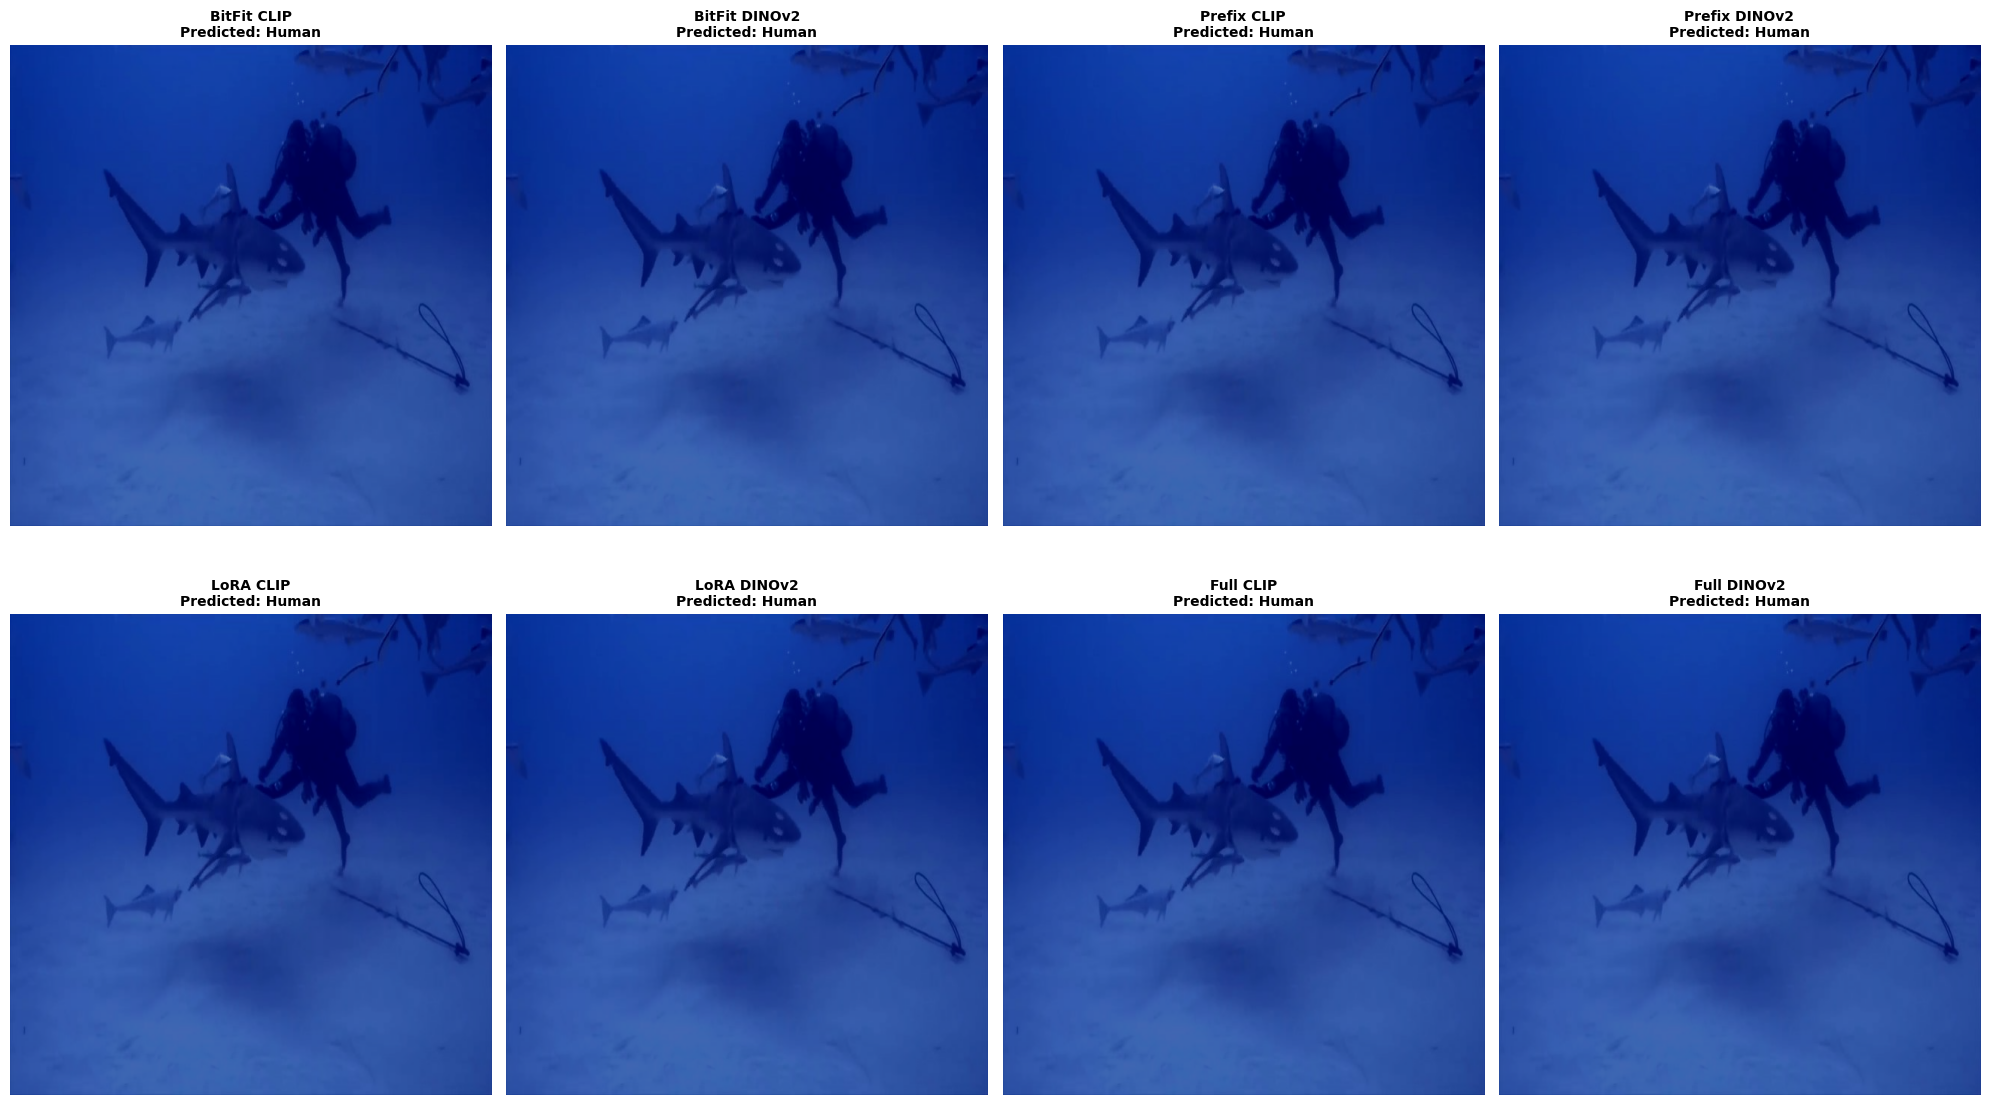

In [18]:
# ============================================================================
# GRAD-CAM VISUALIZATION EXAMPLE
# ============================================================================

# Visualize Grad-CAM for all fine-tuned models
image_path = "balanced_dataset/test/Human/d_r_22__jpg.rf.21b8a44730be9c4c5070e5e955019e2c.jpg"

# Option 1: Visualize all models
visualize_gradcam_for_models(image_path, checkpoint_dir="checkpoints")

# Option 2: Visualize specific models only
# models_to_viz = ['BitFit CLIP', 'LoRA DINOv2', 'Full DINOv2']
# visualize_gradcam_for_models(image_path, checkpoint_dir="checkpoints", 
#                              models_to_visualize=models_to_viz)